In [1]:
import os
import warnings
import json
import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.bag as db
import dask.dataframe as dd
import tensorflow as tf
import keras.applications.inception_resnet_v2 as inception_resnet
from keras import backend
from keras.models import Model, Input, Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Input, Conv2D
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau)
from PIL import Image
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter
from imblearn.over_sampling import SMOTE 
from tqdm.notebook import tqdm

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Tensor Flow Version: 2.4.0
Keras Version: 2.4.0
GPU is available


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from IPython.display import display, clear_output
from IPython.display import Audio
from IPython.core.display import HTML
import numpy as np

def alert(duration=2):
    """ makes sound on client using javascript (works with remote server) """      
    framerate = 44100
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    display(Audio(data,rate=framerate, autoplay=True))

# Constant Variables

In [5]:
BUCKET = 'kapeles'
DATA_PATH ='BDCC_Dataset/downloads/manual'
TRAIN_PATH =  os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample')

VECTOR_PATH = 'BDCC_Dataset/inception_resnet_vectors'
TARGET_SIZE = (1024, 1024)

# Extract image vectors based on InceptionResNetV2

## Create Inception Resnset V2 base

In [6]:
# Inception Resnet V2 base without top layer and specified input shape
base = inception_resnet.InceptionResNetV2(weights='imagenet',
                                          include_top=False,
                                          input_shape=(TARGET_SIZE +
                                                       tuple([3])),
                                          pooling='avg')
# Freeze layers
for layer in base.layers:
    layer.trainable=False
base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 511, 511, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 511, 511, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 511, 511, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

## Predict each images using Inception Resnet V2 base

In [7]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(BUCKET)

In [7]:
def get_image(key, bucket):
    """Return numpy array of image from the s3 bucket"""
    obj = bucket.Object(key)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream).resize(TARGET_SIZE)
    return np.array(im)
    

def write_json_file(data, filename):
    """Write json file in the VECTOR_PATH"""
    key = os.path.join(VECTOR_PATH, filename)
    (s3.Object(BUCKET, key)
     .put(Body=bytes(json.dumps(data).encode('UTF-8'))))
    

def read_json_file(filename):
    """Reads json file in the VECTOR_PATH"""
    obj = bucket.Object(os.path.join(VECTOR_PATH, filename))
    response = obj.get()
    file_content = response['Body'].read()
    return json.loads(file_content)

In [ ]:
file_no = 100
train_images = list(bucket.objects.filter(Prefix=TRAIN_PATH))
count = len(train_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in tqdm(range(count)):
    obj = train_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'train_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

Extracting image vectors for 35127 images


In [ ]:
file_no = 100
test_images = list(bucket.objects.filter(Prefix=TEST_PATH))
count = len(test_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in tqdm(range(count)):
    obj = test_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'test_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [56]:
file_no = 100
sample_images = list(bucket.objects.filter(Prefix=SAMPLE_PATH))
count = len(sample_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in tqdm(range(count)):
    obj = sample_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'sample_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

Extracting image vectors for 11 images


Unable to read 10:BDCC_Dataset/downloads/manual/sampleSubmission.csv



# Setup

## Create Dask Cluster

In [7]:
# Create dask cluster
client = Client('172.31.31.30:8786')

# Register progress bar
pbar = ProgressBar()
pbar.register()

# Get AWS Config
with open('setting_aws.pkl', 'rb') as f:
    settings_aws = pickle.load(f)

# Show cluster
client

Client Scheduler: tcp://172.31.31.30:8786 Dashboard: http://172.31.31.30:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.68 GB


# Prepare dataset

In [8]:
test_label_path = ('s3://kapeles/BDCC_Dataset/downloads/'
                   'kagg-foru-mess-atta_9052_2877_reti_solupq'
                   '89ZoBOgYh9qJuSYbz7faT1us7bBw8bXbg_qHmrYMk.csv')
train_label_path = ('s3://kapeles/BDCC_Dataset/downloads/manual'
                    '/trainLabels.csv')
train_label = dd.read_csv(train_label_path, storage_options=settings_aws)
test_label = dd.read_csv(test_label_path,
                         usecols=['image', 'level'],
                         storage_options=settings_aws)

all_labels = train_label.append(test_label).compute()
all_labels.image = all_labels.image.apply(lambda x: str(x)+'.jpeg')
del train_label_path, test_label_path, train_label, test_label

In [9]:
test_label_path = ('s3://kapeles/BDCC_Dataset/downloads/'
                   'kagg-foru-mess-atta_9052_2877_reti_solupq'
                   '89ZoBOgYh9qJuSYbz7faT1us7bBw8bXbg_qHmrYMk.csv')
test_label = dd.read_csv(test_label_path,
                         usecols=['image', 'level'],
                         storage_options=settings_aws)

## Split dataset 60 20 20

In [10]:
x_train, x_test, y_train, y_test = train_test_split(all_labels.image,
                                                    all_labels.level,
                                                    test_size=0.2,
                                                    random_state=2021)
train_labels = all_labels.loc[all_labels.image.isin(x_train)]
x_train, x_val, y_train, y_val = train_test_split(train_labels.image,
                                                  train_labels.level,
                                                  test_size=0.25,
                                                  random_state=2021)

del all_labels, train_labels

## Perform sampling to solve imbalance data

In [11]:
y_train.value_counts()

0    39214
2     7863
1     3722
3     1279
4     1142
Name: level, dtype: int64

### Original Sampling

In [19]:
n_samples = int(y_train.value_counts().max())
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
new_x_train, new_y_train = pd.Series(dtype='object'), pd.Series(dtype='int32')
for cls in y_train.unique():
    idx = y_train[y_train==cls].index
    x = x_train.loc[idx]
    y = y_train.loc[idx]
    
    new_x, new_y = resample(x, y, replace=True, n_samples=n_samples,
                            random_state=2021)
    new_x_train = new_x_train.append(new_x)
    new_y_train = new_y_train.append(new_y)

x_train, y_train = new_x_train, new_y_train
del new_x_train, new_y_train

In [20]:
y_train.value_counts()

4    39214
3    39214
2    39214
1    39214
0    39214
dtype: int64

## Create Generator

Create a data generator to get batches from train data.

In [11]:
def data_generator(captions, data, batch_size):
    """
    Create a generator that for 2 inputs (image vector, caption sequence)
    output is the next word in the sequence

    Parameters
    ----------
        captions : dict
            image filename as key and level as value
        data : dask bag
            image filaname as key and vectors from convolutional base as value
        img_map : list or iterator
            list or iterator to include, exclude data not in the img_map
        batch_size : int
            batch_size
    
    Returns
    -------
        result : 2 tuples
            first element is the 2 inputs image vector from the convolutional
            base and text to sequence of the caption
            second element is the output is the next word in the sequence
            ([image_vector, sequence], next_word)
    """
    x, y = [], []
    n = 0
    while 1:
        for image_name, vector in data.items():
            # Get image vector based on the convolutional base
            target = captions[image_name]
            # Set the value of target to binary
            target = to_categorical([target], num_classes=5)[0]
            x.append(vector)
            y.append(target)
            n += 1
            if n == batch_size:
                yield np.array(x), np.array(y)
                x, y = [], []
                n = 0

## Read data using Dask Bag

In [12]:
def join_dict(x, y):
    """Update dictionary x with values of dictionary y"""
    x.update(y)
    return x

In [13]:
# Read training data from S3
data = (db.read_text(os.path.join('s3://', BUCKET, VECTOR_PATH, '*.json'),
                     storage_options=settings_aws)
        .map(json.loads)
        .flatten()
        .persist())

In [14]:
train_data = (data.filter(lambda x: x['name'] in x_train.values)
              .map(lambda x: {x['name']: np.asarray(x['value'])})
              .fold(binop=lambda x, y: join_dict(x, y),
                    combine=lambda x, y: join_dict(x, y))
              .compute())

In [15]:
val_data = (data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

In [16]:
# Make train labels to dictionary for easier implementation
train_labels = pd.Series(y_train.values,index=x_train.values).to_dict()
val_labels = pd.Series(y_val.values, index=x_val.values).to_dict()

# Training the model

In [17]:
def evaluate(y_true, y_pred):
    """Calculate and print the accuracy, confusion matrix, and precision"""
    print('Accuracy:', metrics.accuracy_score(y_true, y_pred))
    print('Classification Report')
    print(metrics.classification_report(y_true, y_pred, digits=3,
                                        labels=np.unique(y_true)))
    # Display Confusion matrix
    conf = metrics.confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm.applymap(int), annot=True, fmt='g') # font size
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

    del df_cm, conf

In [18]:
val = [[vector, val_labels[img_fn]] for img_fn, vector in val_data.items()]
x_val_vec = np.array(list(map(lambda x: x[0], val)))
y_val_true = list(map(lambda x: x[1], val))

y_val_bin = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_val_true)))
del val

## Resample Max

In [42]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   cooldown=3,
                                   verbose=0,
                                   min_lr=0.0001)
early = EarlyStopping(monitor="val_accuracy", 
                      verbose=0,
                      patience=30)

### Base

In [30]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [31]:
batch_size = 1024
train_gen = data_generator(train_labels, train_data, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels) // batch_size
val_steps = len(val_labels) // batch_size

In [32]:
model_fp = 'tune/resample_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [35]:
model = create_toplayers()
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 3s 34ms/step - loss: 1.1484 - accuracy: 0.5980 - val_loss: 0.8357 - val_accuracy: 0.7361

Epoch 00001: val_accuracy improved from -inf to 0.73610, saving model to tune/resample_base.h5
Epoch 2/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9884 - accuracy: 0.6391 - val_loss: 0.8196 - val_accuracy: 0.7363

Epoch 00002: val_accuracy improved from 0.73610 to 0.73633, saving model to tune/resample_base.h5
Epoch 3/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9541 - accuracy: 0.6441 - val_loss: 0.7936 - val_accuracy: 0.7412

Epoch 00003: val_accuracy improved from 0.73633 to 0.74121, saving model to tune/resample_base.h5
Epoch 4/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9369 - accuracy: 0.6490 - val_loss: 0.7738 - val_accuracy: 0.7451

Epoch 00004: val_accuracy improved from 0.74121 to 0.74512, saving model to tune/resample_base.h5
Epoch 5/200
37/37 [====================

37/37 [==============================] - 1s 29ms/step - loss: 0.8562 - accuracy: 0.6794 - val_loss: 0.7081 - val_accuracy: 0.7686

Epoch 00037: val_accuracy did not improve from 0.76930
Epoch 38/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8487 - accuracy: 0.6808 - val_loss: 0.7087 - val_accuracy: 0.7691

Epoch 00038: val_accuracy did not improve from 0.76930
Epoch 39/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8550 - accuracy: 0.6834 - val_loss: 0.7077 - val_accuracy: 0.7687

Epoch 00039: val_accuracy did not improve from 0.76930

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 40/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8513 - accuracy: 0.6828 - val_loss: 0.6973 - val_accuracy: 0.7688

Epoch 00040: val_accuracy did not improve from 0.76930
Epoch 41/200
37/37 [==============================] - 1s 28ms/step - loss: 0.8527 - accuracy: 0.6830 - val_loss: 0.6982 - val_accuracy:

37/37 [==============================] - 1s 29ms/step - loss: 0.8308 - accuracy: 0.6919 - val_loss: 0.6975 - val_accuracy: 0.7728

Epoch 00116: val_accuracy did not improve from 0.77344
Epoch 117/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8341 - accuracy: 0.6899 - val_loss: 0.6947 - val_accuracy: 0.7734

Epoch 00117: val_accuracy did not improve from 0.77344
Epoch 118/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8348 - accuracy: 0.6920 - val_loss: 0.6947 - val_accuracy: 0.7733

Epoch 00118: val_accuracy did not improve from 0.77344
Epoch 119/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8357 - accuracy: 0.6885 - val_loss: 0.6921 - val_accuracy: 0.7741

Epoch 00119: val_accuracy improved from 0.77344 to 0.77413, saving model to tune/resample_base.h5
Epoch 120/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8343 - accuracy: 0.6894 - val_loss: 0.6926 - val_accuracy: 0.7726

Epoch 00120: val_accuracy 

In [137]:
model = load_model('tune/resample_base.h5')


In [237]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7739753058578114
Classification Report
              precision    recall  f1-score   support

           0      0.802     0.970     0.878     13063
           1      0.000     0.000     0.000      1252
           2      0.541     0.300     0.386      2677
           3      0.530     0.211     0.302       375
           4      0.556     0.457     0.501       370

    accuracy                          0.774     17737
   macro avg      0.486     0.388     0.413     17737
weighted avg      0.695     0.774     0.722     17737



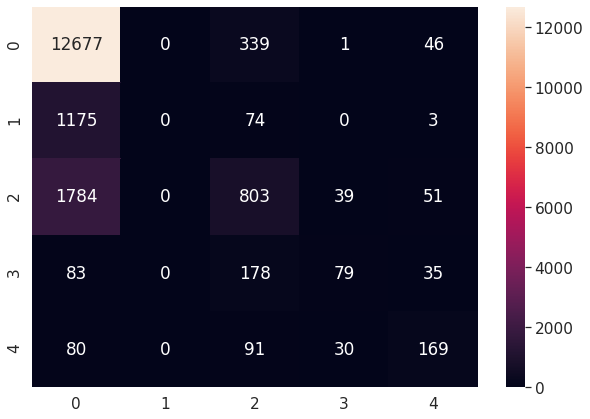

In [274]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [368]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [369]:
batch_size = 1024
train_gen = data_generator(train_labels, train_data, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels) // batch_size
val_steps = len(val_labels) // batch_size

In [370]:
model_fp = 'tune/resample_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [371]:
model = create_toplayers()
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.1157 - accuracy: 0.5736 - val_loss: 0.7984 - val_accuracy: 0.7337

Epoch 00001: val_accuracy improved from -inf to 0.73374, saving model to tune/resample_dropToDense.h5
Epoch 2/200
37/37 [==============================] - 1s 27ms/step - loss: 0.9427 - accuracy: 0.6468 - val_loss: 0.7518 - val_accuracy: 0.7441

Epoch 00002: val_accuracy improved from 0.73374 to 0.74408, saving model to tune/resample_dropToDense.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9010 - accuracy: 0.6605 - val_loss: 0.7667 - val_accuracy: 0.7388

Epoch 00003: val_accuracy did not improve from 0.74408
Epoch 4/200
37/37 [==============================] - 1s 27ms/step - loss: 0.8793 - accuracy: 0.6676 - val_loss: 0.7419 - val_accuracy: 0.7538

Epoch 00004: val_accuracy improved from 0.74408 to 0.75379, saving model to tune/resample_dropToDense.h5
Epoch 5/200
37/37 [==============================] - 1s 27ms/

37/37 [==============================] - 1s 27ms/step - loss: 0.6610 - accuracy: 0.7600 - val_loss: 0.6590 - val_accuracy: 0.7741

Epoch 00079: val_accuracy did not improve from 0.79102
Epoch 80/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6582 - accuracy: 0.7621 - val_loss: 0.6760 - val_accuracy: 0.7649

Epoch 00080: val_accuracy did not improve from 0.79102


In [373]:
model = load_model('tune/resample_dropToDense.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7903253086767773
Classification Report
              precision    recall  f1-score   support

           0      0.825     0.966     0.890     13063
           1      1.000     0.001     0.002      1252
           2      0.580     0.406     0.478      2677
           3      0.457     0.371     0.409       375
           4      0.646     0.478     0.550       370

    accuracy                          0.790     17737
   macro avg      0.702     0.444     0.466     17737
weighted avg      0.789     0.790     0.748     17737



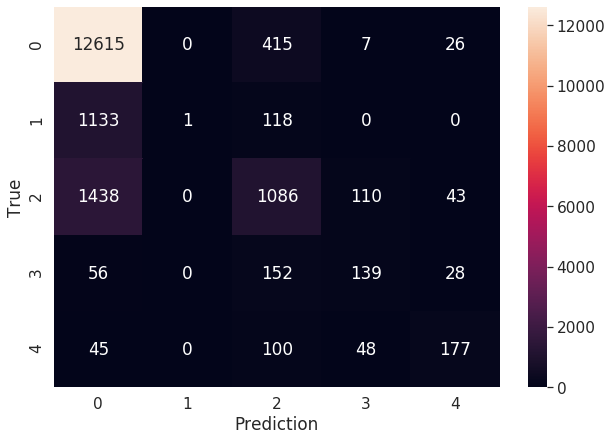

In [374]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [382]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [383]:
batch_size = 1024
train_gen = data_generator(train_labels, train_data, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels) // batch_size
val_steps = len(val_labels) // batch_size

In [384]:
model_fp = 'tune/resample_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [385]:
model = create_toplayers()
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          class_weight={0:1, 1:8, 2:2, 3:2, 4:4},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 2.7109 - accuracy: 0.2611 - val_loss: 1.1311 - val_accuracy: 0.3641

Epoch 00001: val_accuracy improved from -inf to 0.36414, saving model to tune/resample_dropToDense_weighted.h5
Epoch 2/200
37/37 [==============================] - 1s 27ms/step - loss: 2.3536 - accuracy: 0.3142 - val_loss: 1.0528 - val_accuracy: 0.5363

Epoch 00002: val_accuracy improved from 0.36414 to 0.53631, saving model to tune/resample_dropToDense_weighted.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 2.2532 - accuracy: 0.3812 - val_loss: 1.1971 - val_accuracy: 0.2360

Epoch 00003: val_accuracy did not improve from 0.53631
Epoch 4/200
37/37 [==============================] - 1s 27ms/step - loss: 2.2093 - accuracy: 0.3916 - val_loss: 1.2726 - val_accuracy: 0.1750

Epoch 00004: val_accuracy did not improve from 0.53631
Epoch 5/200
37/37 [==============================] - 1s 27ms/step - loss: 2.1891 - accuracy: 

In [386]:
model = load_model('tune/resample_dropToDense_weighted.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6837120144331059
Classification Report
              precision    recall  f1-score   support

           0      0.841     0.822     0.831     13063
           1      0.123     0.284     0.172      1252
           2      0.513     0.285     0.366      2677
           3      0.556     0.147     0.232       375
           4      0.431     0.584     0.496       370

    accuracy                          0.684     17737
   macro avg      0.493     0.424     0.419     17737
weighted avg      0.726     0.684     0.695     17737



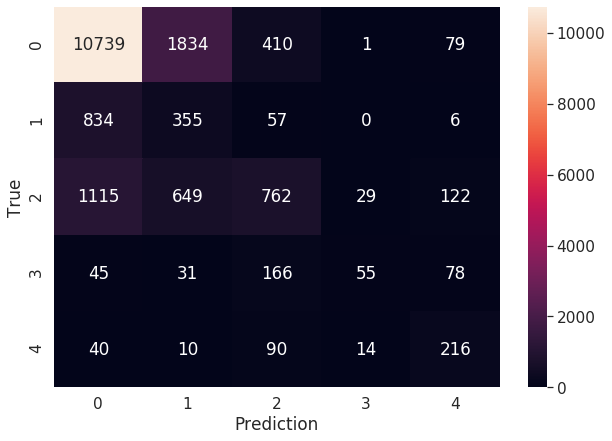

In [387]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [414]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [415]:
batch_size = 1024
train_gen = data_generator(train_labels, train_data, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels) // batch_size
val_steps = len(val_labels) // batch_size

In [416]:
model_fp = 'tune/resample_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [417]:
model = create_toplayers()
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
#           class_weight={0:1, 1:11, 2:2, 3:2, 4:3},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.1631 - accuracy: 0.5812 - val_loss: 0.8174 - val_accuracy: 0.7337

Epoch 00001: val_accuracy improved from -inf to 0.73374, saving model to tune/resample_moreDense.h5
Epoch 2/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9550 - accuracy: 0.6404 - val_loss: 0.7648 - val_accuracy: 0.7386

Epoch 00002: val_accuracy improved from 0.73374 to 0.73857, saving model to tune/resample_moreDense.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9043 - accuracy: 0.6570 - val_loss: 0.7480 - val_accuracy: 0.7496

Epoch 00003: val_accuracy improved from 0.73857 to 0.74960, saving model to tune/resample_moreDense.h5
Epoch 4/200
37/37 [==============================] - 1s 26ms/step - loss: 0.8784 - accuracy: 0.6683 - val_loss: 0.7572 - val_accuracy: 0.7509

Epoch 00004: val_accuracy improved from 0.74960 to 0.75092, saving model to tune/resample_moreDense.h5
Epoch 5/200
37/37 [

37/37 [==============================] - 1s 26ms/step - loss: 0.6299 - accuracy: 0.7720 - val_loss: 0.6451 - val_accuracy: 0.7872

Epoch 00078: val_accuracy did not improve from 0.79383
Epoch 79/200
37/37 [==============================] - 1s 26ms/step - loss: 0.6269 - accuracy: 0.7738 - val_loss: 0.6527 - val_accuracy: 0.7824

Epoch 00079: val_accuracy did not improve from 0.79383
Epoch 80/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6216 - accuracy: 0.7783 - val_loss: 0.6650 - val_accuracy: 0.7759

Epoch 00080: val_accuracy did not improve from 0.79383
Epoch 81/200
37/37 [==============================] - 1s 26ms/step - loss: 0.6221 - accuracy: 0.7783 - val_loss: 0.6698 - val_accuracy: 0.7731

Epoch 00081: val_accuracy did not improve from 0.79383
Epoch 82/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6174 - accuracy: 0.7797 - val_loss: 0.6706 - val_accuracy: 0.7740

Epoch 00082: val_accuracy did not improve from 0.79383
Epoch 83/200
37/37

In [418]:
model = load_model('tune/resample_moreDense.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7934825506004397
Classification Report
              precision    recall  f1-score   support

           0      0.829     0.965     0.892     13063
           1      0.667     0.002     0.003      1252
           2      0.586     0.443     0.505      2677
           3      0.461     0.331     0.385       375
           4      0.686     0.408     0.512       370

    accuracy                          0.793     17737
   macro avg      0.646     0.430     0.459     17737
weighted avg      0.770     0.793     0.752     17737



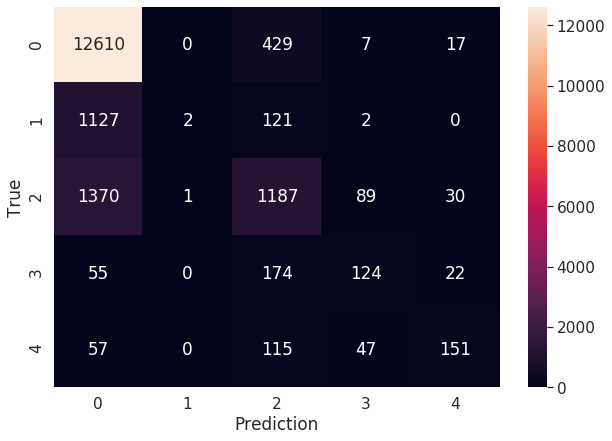

In [419]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [420]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [421]:
batch_size = 1024
train_gen = data_generator(train_labels, train_data, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels) // batch_size
val_steps = len(val_labels) // batch_size

In [422]:
model_fp = 'tune/resample_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [423]:
model = create_toplayers()
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
#           class_weight={0:1, 1:11, 2:2, 3:2, 4:3},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.4694 - accuracy: 0.6113 - val_loss: 0.8405 - val_accuracy: 0.7367

Epoch 00001: val_accuracy improved from -inf to 0.73667, saving model to tune/resample_moreDense_bias.h5
Epoch 2/200
37/37 [==============================] - 1s 26ms/step - loss: 1.0089 - accuracy: 0.6388 - val_loss: 0.7873 - val_accuracy: 0.7336

Epoch 00002: val_accuracy did not improve from 0.73667
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9340 - accuracy: 0.6481 - val_loss: 0.7507 - val_accuracy: 0.7432

Epoch 00003: val_accuracy improved from 0.73667 to 0.74316, saving model to tune/resample_moreDense_bias.h5
Epoch 4/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9021 - accuracy: 0.6581 - val_loss: 0.7795 - val_accuracy: 0.7416

Epoch 00004: val_accuracy did not improve from 0.74316
Epoch 5/200
37/37 [==============================] - 1s 26ms/step - loss: 0.8866 - accuracy: 0.6636 - val

37/37 [==============================] - 1s 27ms/step - loss: 0.7341 - accuracy: 0.7305 - val_loss: 0.6526 - val_accuracy: 0.7811

Epoch 00039: val_accuracy did not improve from 0.78470
Epoch 40/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7313 - accuracy: 0.7322 - val_loss: 0.6477 - val_accuracy: 0.7844

Epoch 00040: val_accuracy did not improve from 0.78470
Epoch 41/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7336 - accuracy: 0.7292 - val_loss: 0.6503 - val_accuracy: 0.7830

Epoch 00041: val_accuracy did not improve from 0.78470
Epoch 42/200
37/37 [==============================] - 1s 27ms/step - loss: 0.7309 - accuracy: 0.7333 - val_loss: 0.6781 - val_accuracy: 0.7696

Epoch 00042: val_accuracy did not improve from 0.78470
Epoch 43/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7238 - accuracy: 0.7359 - val_loss: 0.6382 - val_accuracy: 0.7858

Epoch 00043: val_accuracy improved from 0.78470 to 0.78579, saving model 


Epoch 00119: val_accuracy did not improve from 0.78935
Epoch 120/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6335 - accuracy: 0.7710 - val_loss: 0.6802 - val_accuracy: 0.7649

Epoch 00120: val_accuracy did not improve from 0.78935
Epoch 121/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6328 - accuracy: 0.7716 - val_loss: 0.6479 - val_accuracy: 0.7842

Epoch 00121: val_accuracy did not improve from 0.78935
Epoch 122/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6286 - accuracy: 0.7731 - val_loss: 0.6426 - val_accuracy: 0.7875

Epoch 00122: val_accuracy did not improve from 0.78935
Epoch 123/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6254 - accuracy: 0.7740 - val_loss: 0.6493 - val_accuracy: 0.7849

Epoch 00123: val_accuracy did not improve from 0.78935
Epoch 124/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6245 - accuracy: 0.7758 - val_loss: 0.6736 - val_accuracy: 0.7729


In [424]:
model = load_model('tune/resample_moreDense_bias.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7898178947961888
Classification Report
              precision    recall  f1-score   support

           0      0.825     0.964     0.889     13063
           1      0.250     0.002     0.005      1252
           2      0.562     0.436     0.491      2677
           3      0.556     0.213     0.308       375
           4      0.703     0.449     0.548       370

    accuracy                          0.790     17737
   macro avg      0.579     0.413     0.448     17737
weighted avg      0.736     0.790     0.747     17737



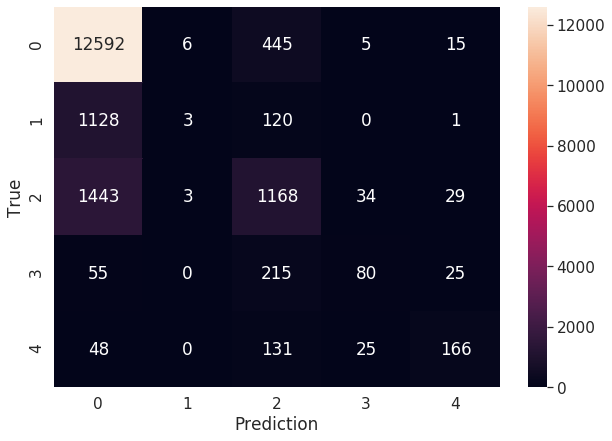

In [425]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

## SMOTE balance all classes

Run smote if no prior re-sampling performed

In [22]:
train = [[vector, train_labels[img_fn]]
         for img_fn, vector in train_data.items()]
x_train_vec = np.array(list(map(lambda x: x[0], train)))
y_train_true = list(map(lambda x: x[1], train))
del train

In [24]:
sm = SMOTE(random_state=1)
x_train_sm, y_train_sm = sm.fit_sample(x_train_vec, y_train_true)

In [57]:
x_train_sm = np.array(x_train_sm)
y_train_true = y_train_sm
y_train_sm = np.array(list(map(lambda x: to_categorical([x],
                                                        num_classes=5)[0],
                               y_train_sm)))

In [99]:
Counter(y_train_true)

Counter({0: 39208, 2: 39208, 1: 39208, 4: 39208, 3: 39208})

In [44]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   cooldown=3,
                                   verbose=0,
                                   min_lr=0.0001)
early = EarlyStopping(monitor="val_accuracy", 
                      verbose=0,
                      patience=30)

### Base

In [36]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [37]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [53]:
model_fp = 'tune/smote_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [60]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 1s 5ms/step - loss: 1.3397 - accuracy: 0.3946 - val_loss: 1.1697 - val_accuracy: 0.4164

Epoch 00001: val_accuracy improved from -inf to 0.41642, saving model to tune/smote_base.h5
Epoch 2/200
191/191 [==============================] - 1s 4ms/step - loss: 1.1336 - accuracy: 0.4948 - val_loss: 1.2311 - val_accuracy: 0.3727

Epoch 00002: val_accuracy did not improve from 0.41642
Epoch 3/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0947 - accuracy: 0.5160 - val_loss: 1.2314 - val_accuracy: 0.3154

Epoch 00003: val_accuracy did not improve from 0.41642
Epoch 4/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0716 - accuracy: 0.5252 - val_loss: 1.1299 - val_accuracy: 0.4719

Epoch 00004: val_accuracy improved from 0.41642 to 0.47185, saving model to tune/smote_base.h5
Epoch 5/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0569 - accuracy: 0.5343 - val_loss: 1.1783 - val_a

In [61]:
model = load_model('tune/smote_base.h5')

In [62]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6117720020296555
Classification Report
              precision    recall  f1-score   support

           0      0.853     0.717     0.779     13063
           1      0.124     0.290     0.173      1252
           2      0.356     0.251     0.295      2677
           3      0.210     0.547     0.303       375
           4      0.263     0.676     0.378       370

    accuracy                          0.612     17737
   macro avg      0.361     0.496     0.386     17737
weighted avg      0.700     0.612     0.644     17737



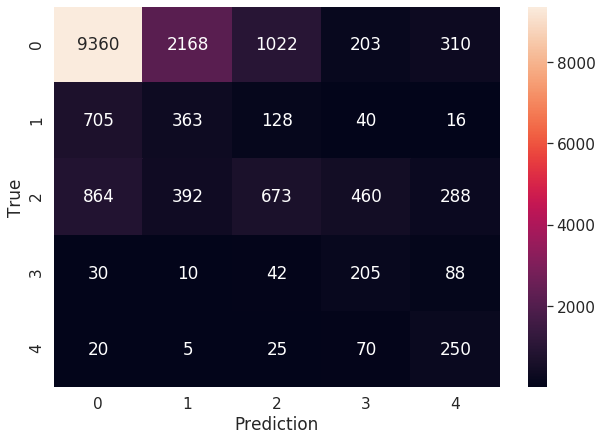

In [63]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [69]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [70]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [71]:
model_fp = 'tune/smote_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [72]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 7ms/step - loss: 1.2664 - accuracy: 0.4300 - val_loss: 1.0652 - val_accuracy: 0.5475

Epoch 00001: val_accuracy improved from -inf to 0.54751, saving model to tune/smote_dropToDense.h5
Epoch 2/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9881 - accuracy: 0.5667 - val_loss: 1.1655 - val_accuracy: 0.4457

Epoch 00002: val_accuracy did not improve from 0.54751
Epoch 3/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9299 - accuracy: 0.5916 - val_loss: 0.8915 - val_accuracy: 0.6303

Epoch 00003: val_accuracy improved from 0.54751 to 0.63034, saving model to tune/smote_dropToDense.h5
Epoch 4/200
191/191 [==============================] - 1s 5ms/step - loss: 0.8713 - accuracy: 0.6207 - val_loss: 0.9201 - val_accuracy: 0.5851

Epoch 00004: val_accuracy did not improve from 0.63034
Epoch 5/200
191/191 [==============================] - 1s 5ms/step - loss: 0.8118 - accuracy: 0.6505 - val_loss: 

191/191 [==============================] - 1s 6ms/step - loss: 0.1478 - accuracy: 0.9482 - val_loss: 1.2775 - val_accuracy: 0.6688

Epoch 00041: val_accuracy did not improve from 0.70824
Epoch 42/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1407 - accuracy: 0.9523 - val_loss: 1.2506 - val_accuracy: 0.6888

Epoch 00042: val_accuracy did not improve from 0.70824
Epoch 43/200
191/191 [==============================] - 1s 6ms/step - loss: 0.1416 - accuracy: 0.9511 - val_loss: 1.2602 - val_accuracy: 0.6903

Epoch 00043: val_accuracy did not improve from 0.70824
Epoch 44/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1338 - accuracy: 0.9548 - val_loss: 1.2701 - val_accuracy: 0.6935

Epoch 00044: val_accuracy did not improve from 0.70824
Epoch 45/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1322 - accuracy: 0.9545 - val_loss: 1.3139 - val_accuracy: 0.6692

Epoch 00045: val_accuracy did not improve from 0.70824
Epoch 46/200


191/191 [==============================] - 1s 6ms/step - loss: 0.0621 - accuracy: 0.9812 - val_loss: 1.6940 - val_accuracy: 0.6874

Epoch 00081: val_accuracy did not improve from 0.73460
Epoch 82/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0615 - accuracy: 0.9810 - val_loss: 1.7335 - val_accuracy: 0.6848

Epoch 00082: val_accuracy did not improve from 0.73460
Epoch 83/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0590 - accuracy: 0.9819 - val_loss: 1.7062 - val_accuracy: 0.7107

Epoch 00083: val_accuracy did not improve from 0.73460
Epoch 84/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0605 - accuracy: 0.9812 - val_loss: 1.7179 - val_accuracy: 0.7111

Epoch 00084: val_accuracy did not improve from 0.73460
Epoch 85/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0592 - accuracy: 0.9819 - val_loss: 1.7069 - val_accuracy: 0.7116

Epoch 00085: val_accuracy did not improve from 0.73460
Epoch 86/200


In [73]:
model = load_model('tune/smote_dropToDense.h5')

In [74]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7340023679314428
Classification Report
              precision    recall  f1-score   support

           0      0.828     0.885     0.856     13063
           1      0.132     0.100     0.114      1252
           2      0.477     0.387     0.427      2677
           3      0.376     0.347     0.361       375
           4      0.533     0.457     0.492       370

    accuracy                          0.734     17737
   macro avg      0.469     0.435     0.450     17737
weighted avg      0.710     0.734     0.721     17737



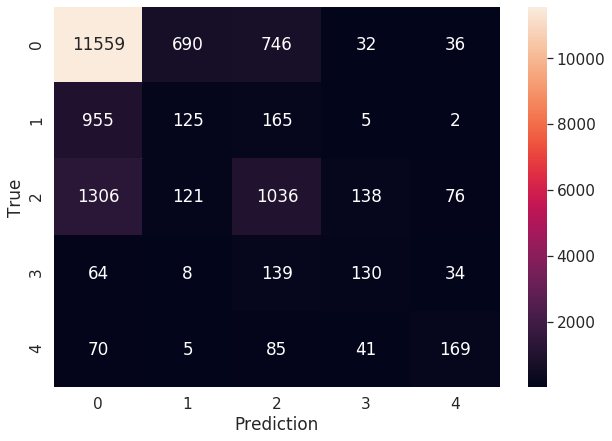

In [75]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [77]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [78]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [79]:
model_fp = 'tune/smote_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [80]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 8ms/step - loss: 1.2692 - accuracy: 0.4254 - val_loss: 1.0331 - val_accuracy: 0.5665

Epoch 00001: val_accuracy improved from -inf to 0.56646, saving model to tune/smote_dropToDense_weighted.h5
Epoch 2/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9881 - accuracy: 0.5657 - val_loss: 1.1751 - val_accuracy: 0.4743

Epoch 00002: val_accuracy did not improve from 0.56646
Epoch 3/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9339 - accuracy: 0.5914 - val_loss: 1.3931 - val_accuracy: 0.2772

Epoch 00003: val_accuracy did not improve from 0.56646
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.8805 - accuracy: 0.6174 - val_loss: 1.0956 - val_accuracy: 0.4746

Epoch 00004: val_accuracy did not improve from 0.56646
Epoch 5/200
191/191 [==============================] - 1s 5ms/step - loss: 0.7887 - accuracy: 0.6628 - val_loss: 1.1270 - val_accuracy: 0.4235

Epoch 0

Epoch 39/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.9589 - val_loss: 1.3142 - val_accuracy: 0.7043

Epoch 00039: val_accuracy did not improve from 0.71685
Epoch 40/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1142 - accuracy: 0.9609 - val_loss: 1.3237 - val_accuracy: 0.7137

Epoch 00040: val_accuracy did not improve from 0.71685
Epoch 41/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1139 - accuracy: 0.9610 - val_loss: 1.3309 - val_accuracy: 0.7421

Epoch 00041: val_accuracy improved from 0.71685 to 0.74207, saving model to tune/smote_dropToDense_weighted.h5
Epoch 42/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1140 - accuracy: 0.9602 - val_loss: 1.3692 - val_accuracy: 0.6970

Epoch 00042: val_accuracy did not improve from 0.74207
Epoch 43/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1040 - accuracy: 0.9649 - val_loss: 1.4098 - val_accuracy: 0.6895


In [81]:
model = load_model('tune/smote_dropToDense_weighted.h5')

In [82]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7416135761402718
Classification Report
              precision    recall  f1-score   support

           0      0.827     0.896     0.860     13063
           1      0.141     0.108     0.122      1252
           2      0.511     0.379     0.435      2677
           3      0.399     0.344     0.370       375
           4      0.544     0.451     0.493       370

    accuracy                          0.742     17737
   macro avg      0.484     0.436     0.456     17737
weighted avg      0.716     0.742     0.726     17737



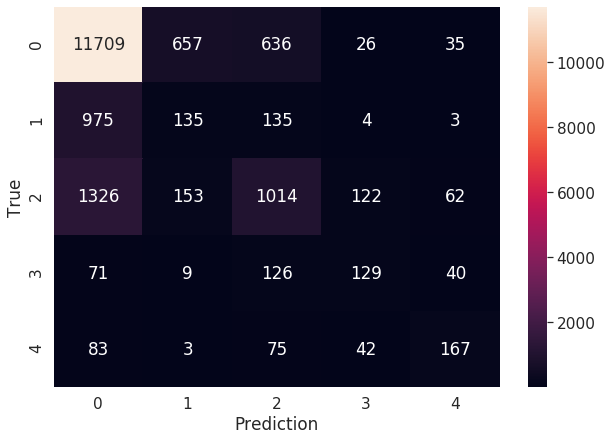

In [83]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [84]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [85]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [86]:
model_fp = 'tune/smote_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [87]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 8ms/step - loss: 1.2480 - accuracy: 0.4322 - val_loss: 1.1627 - val_accuracy: 0.4584

Epoch 00001: val_accuracy improved from -inf to 0.45835, saving model to tune/smote_moreDense.h5
Epoch 2/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9926 - accuracy: 0.5615 - val_loss: 0.9811 - val_accuracy: 0.5735

Epoch 00002: val_accuracy improved from 0.45835 to 0.57353, saving model to tune/smote_moreDense.h5
Epoch 3/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9253 - accuracy: 0.5948 - val_loss: 0.8808 - val_accuracy: 0.6409

Epoch 00003: val_accuracy improved from 0.57353 to 0.64091, saving model to tune/smote_moreDense.h5
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.8730 - accuracy: 0.6199 - val_loss: 1.0093 - val_accuracy: 0.5168

Epoch 00004: val_accuracy did not improve from 0.64091
Epoch 5/200
191/191 [==============================] - 1s 6ms/step - los

191/191 [==============================] - 1s 6ms/step - loss: 0.0808 - accuracy: 0.9721 - val_loss: 1.6951 - val_accuracy: 0.6954

Epoch 00040: val_accuracy did not improve from 0.73420
Epoch 41/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0778 - accuracy: 0.9742 - val_loss: 1.7063 - val_accuracy: 0.6949

Epoch 00041: val_accuracy did not improve from 0.73420
Epoch 42/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0705 - accuracy: 0.9769 - val_loss: 1.7392 - val_accuracy: 0.6926

Epoch 00042: val_accuracy did not improve from 0.73420
Epoch 43/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0709 - accuracy: 0.9770 - val_loss: 1.7581 - val_accuracy: 0.6855

Epoch 00043: val_accuracy did not improve from 0.73420
Epoch 44/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0697 - accuracy: 0.9767 - val_loss: 1.7704 - val_accuracy: 0.6918

Epoch 00044: val_accuracy did not improve from 0.73420
Epoch 45/200


In [88]:
model = load_model('tune/smote_moreDense.h5')

In [89]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7336077126909849
Classification Report
              precision    recall  f1-score   support

           0      0.827     0.884     0.855     13063
           1      0.124     0.111     0.117      1252
           2      0.491     0.387     0.433      2677
           3      0.451     0.320     0.374       375
           4      0.612     0.443     0.514       370

    accuracy                          0.734     17737
   macro avg      0.501     0.429     0.459     17737
weighted avg      0.714     0.734     0.722     17737



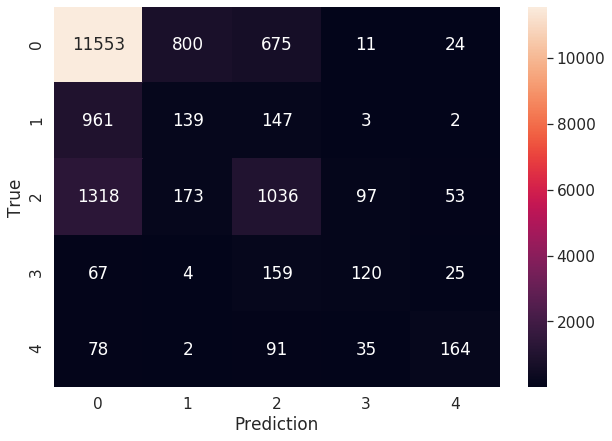

In [90]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [91]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [92]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [93]:
model_fp = 'tune/smote_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [94]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 7ms/step - loss: 1.4183 - accuracy: 0.3739 - val_loss: 1.4089 - val_accuracy: 0.2188

Epoch 00001: val_accuracy improved from -inf to 0.21881, saving model to tune/smote_moreDense_bias.h5
Epoch 2/200
191/191 [==============================] - 1s 6ms/step - loss: 1.0451 - accuracy: 0.5356 - val_loss: 1.1128 - val_accuracy: 0.4751

Epoch 00002: val_accuracy improved from 0.21881 to 0.47507, saving model to tune/smote_moreDense_bias.h5
Epoch 3/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9686 - accuracy: 0.5755 - val_loss: 1.4107 - val_accuracy: 0.2783

Epoch 00003: val_accuracy did not improve from 0.47507
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9194 - accuracy: 0.5985 - val_loss: 0.9499 - val_accuracy: 0.5918

Epoch 00004: val_accuracy improved from 0.47507 to 0.59180, saving model to tune/smote_moreDense_bias.h5
Epoch 5/200
191/191 [==============================] - 1s

191/191 [==============================] - 1s 6ms/step - loss: 0.0989 - accuracy: 0.9649 - val_loss: 1.5836 - val_accuracy: 0.6801

Epoch 00039: val_accuracy did not improve from 0.73053
Epoch 40/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0957 - accuracy: 0.9667 - val_loss: 1.5952 - val_accuracy: 0.6884

Epoch 00040: val_accuracy did not improve from 0.73053
Epoch 41/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0897 - accuracy: 0.9684 - val_loss: 1.6636 - val_accuracy: 0.6743

Epoch 00041: val_accuracy did not improve from 0.73053
Epoch 42/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0783 - accuracy: 0.9736 - val_loss: 1.6596 - val_accuracy: 0.6934

Epoch 00042: val_accuracy did not improve from 0.73053
Epoch 43/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0722 - accuracy: 0.9760 - val_loss: 1.6971 - val_accuracy: 0.7146

Epoch 00043: val_accuracy did not improve from 0.73053
Epoch 44/200


191/191 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 2.8015 - val_accuracy: 0.7317

Epoch 00080: val_accuracy improved from 0.73156 to 0.73168, saving model to tune/smote_moreDense_bias.h5
Epoch 81/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 2.8180 - val_accuracy: 0.7223

Epoch 00081: val_accuracy did not improve from 0.73168
Epoch 82/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 2.4943 - val_accuracy: 0.6974

Epoch 00082: val_accuracy did not improve from 0.73168
Epoch 83/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 2.6567 - val_accuracy: 0.7244

Epoch 00083: val_accuracy did not improve from 0.73168
Epoch 84/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 2.7367 - val_accuracy: 0.7242

Epoch 00084: val_a

191/191 [==============================] - 1s 6ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.1043 - val_accuracy: 0.7291

Epoch 00120: val_accuracy did not improve from 0.73633
Epoch 121/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 3.1424 - val_accuracy: 0.7252

Epoch 00121: val_accuracy did not improve from 0.73633
Epoch 122/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.1843 - val_accuracy: 0.7326

Epoch 00122: val_accuracy did not improve from 0.73633
Epoch 123/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.1876 - val_accuracy: 0.7256

Epoch 00123: val_accuracy did not improve from 0.73633
Epoch 124/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.2253 - val_accuracy: 0.7277

Epoch 00124: val_accuracy did not improve from 0.73633
Epoch 125

In [95]:
model = load_model('tune/smote_moreDense_bias.h5')

In [96]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7356937475334048
Classification Report
              precision    recall  f1-score   support

           0      0.831     0.885     0.857     13063
           1      0.151     0.104     0.123      1252
           2      0.457     0.397     0.425      2677
           3      0.369     0.331     0.349       375
           4      0.565     0.459     0.507       370

    accuracy                          0.736     17737
   macro avg      0.475     0.435     0.452     17737
weighted avg      0.711     0.736     0.722     17737



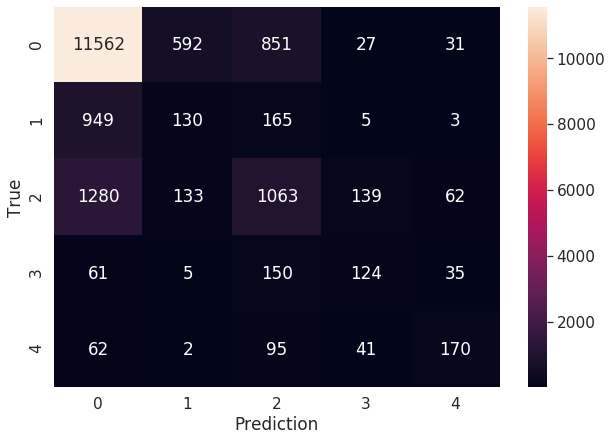

In [97]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

## SMOTE - undersample level 0 to 20k then balance all classes

Run smote if no prior re-sampling performed

In [19]:
train = [[vector, train_labels[img_fn]]
         for img_fn, vector in train_data.items()]
x_train_vec = np.array(list(map(lambda x: x[0], train)))
y_train_true = list(map(lambda x: x[1], train))
del train

Undersample level 0 to 20000

In [20]:
np.bincount(y_train_true)

array([39208,  3718,  7862,  1276,  1142])

In [22]:
n_samples = 20000
y_train_true = np.array(y_train_true)

# Get only class 0
x_train_0 = x_train_vec[y_train_true==0]
y_train_0 = y_train_true[y_train_true==0]

# Resample the class
x_train_0, y_train_0 = resample(x_train_0, y_train_0, replace=False,
                        n_samples=n_samples,
                        random_state=1)

# Remove all class 0 from source
x_train_vec = [x for x, y in zip(x_train_vec, y_train_true)
                        if y != 0]
y_train_true = list(filter(lambda y: y!=0, y_train_true))

# Append resample data of class 0
x_train_vec.extend(x_train_0)
y_train_true.extend(y_train_0)

del x_train_0, y_train_0
np.bincount(y_train_true)

array([20000,  3718,  7862,  1276,  1142])

In [23]:
sm = SMOTE(random_state=1)
x_train_sm, y_train_sm = sm.fit_sample(x_train_vec, y_train_true)

In [24]:
x_train_sm = np.array(x_train_sm)
y_train_true = y_train_sm
y_train_sm = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_train_sm)))

In [25]:
Counter(y_train_true)

Counter({2: 20000, 1: 20000, 4: 20000, 3: 20000, 0: 20000})

In [26]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   cooldown=3,
                                   verbose=0,
                                   min_lr=0.0001)
early = EarlyStopping(monitor="val_accuracy", 
                      verbose=0,
                      patience=30)

### Base

In [27]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [28]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [29]:
model_fp = 'tune/smote2_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [36]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
97/97 [==============================] - 1s 7ms/step - loss: 1.3907 - accuracy: 0.3744 - val_loss: 1.2958 - val_accuracy: 0.3039

Epoch 00001: val_accuracy improved from -inf to 0.30388, saving model to tune/smote2_base.h5
Epoch 2/200
97/97 [==============================] - 0s 4ms/step - loss: 1.1750 - accuracy: 0.4752 - val_loss: 1.1481 - val_accuracy: 0.5261

Epoch 00002: val_accuracy improved from 0.30388 to 0.52614, saving model to tune/smote2_base.h5
Epoch 3/200
97/97 [==============================] - 0s 4ms/step - loss: 1.1307 - accuracy: 0.4989 - val_loss: 1.1081 - val_accuracy: 0.5321

Epoch 00003: val_accuracy improved from 0.52614 to 0.53211, saving model to tune/smote2_base.h5
Epoch 4/200
97/97 [==============================] - 0s 4ms/step - loss: 1.1157 - accuracy: 0.5068 - val_loss: 1.1806 - val_accuracy: 0.3891

Epoch 00004: val_accuracy did not improve from 0.53211
Epoch 5/200
97/97 [==============================] - 0s 4ms/step - loss: 1.0960 - accuracy: 

In [37]:
model = load_model('tune/smote2_base.h5')

In [38]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.5436094040705869
Classification Report
              precision    recall  f1-score   support

           0      0.857     0.616     0.717     13063
           1      0.109     0.391     0.170      1252
           2      0.322     0.244     0.278      2677
           3      0.219     0.555     0.314       375
           4      0.280     0.643     0.390       370

    accuracy                          0.544     17737
   macro avg      0.357     0.490     0.374     17737
weighted avg      0.698     0.544     0.597     17737



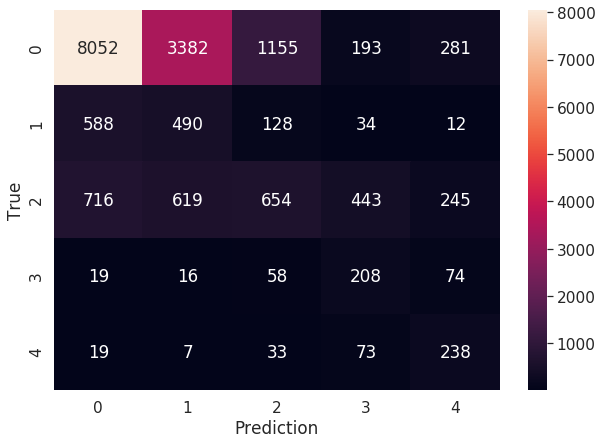

In [39]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [40]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [41]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [42]:
model_fp = 'tune/smote2_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [43]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
97/97 [==============================] - 1s 10ms/step - loss: 1.3448 - accuracy: 0.3874 - val_loss: 1.2359 - val_accuracy: 0.3903

Epoch 00001: val_accuracy improved from -inf to 0.39034, saving model to tune/smote2_dropToDense.h5
Epoch 2/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0685 - accuracy: 0.5249 - val_loss: 1.1085 - val_accuracy: 0.4142

Epoch 00002: val_accuracy improved from 0.39034 to 0.41418, saving model to tune/smote2_dropToDense.h5
Epoch 3/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0170 - accuracy: 0.5497 - val_loss: 1.3408 - val_accuracy: 0.2709

Epoch 00003: val_accuracy did not improve from 0.41418
Epoch 4/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9695 - accuracy: 0.5732 - val_loss: 1.2418 - val_accuracy: 0.3793

Epoch 00004: val_accuracy did not improve from 0.41418
Epoch 5/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9355 - accuracy: 0.5912 - val_loss: 1.3609 


Epoch 00040: val_accuracy did not improve from 0.69324
Epoch 41/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2915 - accuracy: 0.8923 - val_loss: 1.1183 - val_accuracy: 0.5911

Epoch 00041: val_accuracy did not improve from 0.69324
Epoch 42/200
97/97 [==============================] - 2s 20ms/step - loss: 0.2886 - accuracy: 0.8941 - val_loss: 1.0595 - val_accuracy: 0.6243

Epoch 00042: val_accuracy did not improve from 0.69324
Epoch 43/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2795 - accuracy: 0.8975 - val_loss: 1.1049 - val_accuracy: 0.6018

Epoch 00043: val_accuracy did not improve from 0.69324
Epoch 44/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2749 - accuracy: 0.8998 - val_loss: 1.1422 - val_accuracy: 0.5859

Epoch 00044: val_accuracy did not improve from 0.69324
Epoch 45/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2662 - accuracy: 0.9044 - val_loss: 1.0194 - val_accuracy: 0.6642

Epoch 00

In [44]:
model = load_model('tune/smote2_dropToDense.h5')

In [45]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6923944297231776
Classification Report
              precision    recall  f1-score   support

           0      0.856     0.796     0.825     13063
           1      0.131     0.173     0.149      1252
           2      0.424     0.504     0.460      2677
           3      0.346     0.395     0.369       375
           4      0.529     0.473     0.499       370

    accuracy                          0.692     17737
   macro avg      0.457     0.468     0.460     17737
weighted avg      0.722     0.692     0.706     17737



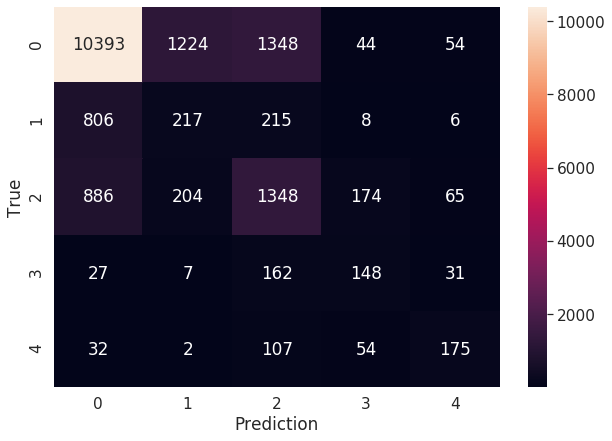

In [46]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [47]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [48]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [49]:
model_fp = 'tune/smote2_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [50]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
97/97 [==============================] - 1s 10ms/step - loss: 1.3597 - accuracy: 0.3781 - val_loss: 1.2397 - val_accuracy: 0.2974

Epoch 00001: val_accuracy improved from -inf to 0.29745, saving model to tune/smote2_dropToDense_weighted.h5
Epoch 2/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0776 - accuracy: 0.5187 - val_loss: 1.0924 - val_accuracy: 0.4555

Epoch 00002: val_accuracy improved from 0.29745 to 0.45548, saving model to tune/smote2_dropToDense_weighted.h5
Epoch 3/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0204 - accuracy: 0.5474 - val_loss: 0.9880 - val_accuracy: 0.6077

Epoch 00003: val_accuracy improved from 0.45548 to 0.60765, saving model to tune/smote2_dropToDense_weighted.h5
Epoch 4/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9617 - accuracy: 0.5762 - val_loss: 1.2525 - val_accuracy: 0.3476

Epoch 00004: val_accuracy did not improve from 0.60765
Epoch 5/200
97/97 [========================


Epoch 00040: val_accuracy did not improve from 0.67607
Epoch 41/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2885 - accuracy: 0.8935 - val_loss: 1.1817 - val_accuracy: 0.5636

Epoch 00041: val_accuracy did not improve from 0.67607
Epoch 42/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2837 - accuracy: 0.8961 - val_loss: 1.0764 - val_accuracy: 0.6217

Epoch 00042: val_accuracy did not improve from 0.67607
Epoch 43/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2752 - accuracy: 0.8987 - val_loss: 1.0081 - val_accuracy: 0.6620

Epoch 00043: val_accuracy did not improve from 0.67607
Epoch 44/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2857 - accuracy: 0.8941 - val_loss: 1.0501 - val_accuracy: 0.6326

Epoch 00044: val_accuracy did not improve from 0.67607
Epoch 45/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2718 - accuracy: 0.9003 - val_loss: 1.0603 - val_accuracy: 0.6393

Epoch 000

In [51]:
model = load_model('tune/smote2_dropToDense_weighted.h5')

In [52]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6929582229238316
Classification Report
              precision    recall  f1-score   support

           0      0.850     0.805     0.827     13063
           1      0.123     0.192     0.150      1252
           2      0.457     0.449     0.453      2677
           3      0.354     0.392     0.372       375
           4      0.510     0.486     0.498       370

    accuracy                          0.693     17737
   macro avg      0.459     0.465     0.460     17737
weighted avg      0.722     0.693     0.706     17737



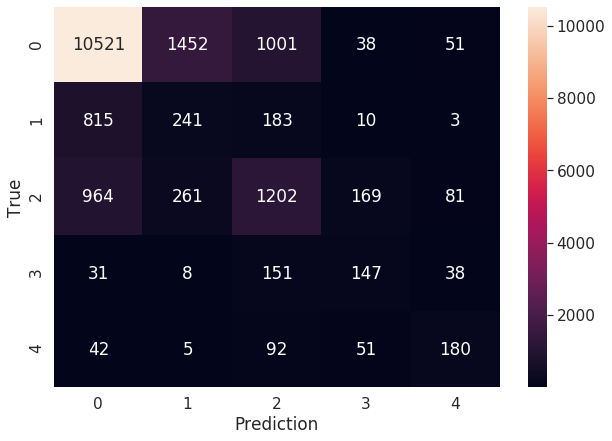

In [53]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [54]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [55]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [56]:
model_fp = 'tune/smote2_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [57]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
97/97 [==============================] - 1s 10ms/step - loss: 1.3649 - accuracy: 0.3697 - val_loss: 1.2949 - val_accuracy: 0.3624

Epoch 00001: val_accuracy improved from -inf to 0.36236, saving model to tune/smote2_moreDense.h5
Epoch 2/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0658 - accuracy: 0.5264 - val_loss: 1.2124 - val_accuracy: 0.3523

Epoch 00002: val_accuracy did not improve from 0.36236
Epoch 3/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0014 - accuracy: 0.5605 - val_loss: 1.0681 - val_accuracy: 0.5122

Epoch 00003: val_accuracy improved from 0.36236 to 0.51218, saving model to tune/smote2_moreDense.h5
Epoch 4/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9638 - accuracy: 0.5748 - val_loss: 1.0538 - val_accuracy: 0.5271

Epoch 00004: val_accuracy improved from 0.51218 to 0.52711, saving model to tune/smote2_moreDense.h5
Epoch 5/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9

97/97 [==============================] - 1s 6ms/step - loss: 0.2502 - accuracy: 0.9057 - val_loss: 1.1043 - val_accuracy: 0.6671

Epoch 00040: val_accuracy improved from 0.66699 to 0.66711, saving model to tune/smote2_moreDense.h5
Epoch 41/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2391 - accuracy: 0.9102 - val_loss: 1.0821 - val_accuracy: 0.6823

Epoch 00041: val_accuracy improved from 0.66711 to 0.68227, saving model to tune/smote2_moreDense.h5
Epoch 42/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2418 - accuracy: 0.9093 - val_loss: 1.2103 - val_accuracy: 0.6240

Epoch 00042: val_accuracy did not improve from 0.68227
Epoch 43/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2291 - accuracy: 0.9140 - val_loss: 1.2387 - val_accuracy: 0.6156

Epoch 00043: val_accuracy did not improve from 0.68227
Epoch 44/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2327 - accuracy: 0.9120 - val_loss: 1.1098 - val_accu


Epoch 00080: val_accuracy did not improve from 0.69727
Epoch 81/200
97/97 [==============================] - 1s 6ms/step - loss: 0.1020 - accuracy: 0.9647 - val_loss: 1.5670 - val_accuracy: 0.6657

Epoch 00081: val_accuracy did not improve from 0.69727
Epoch 82/200
97/97 [==============================] - 1s 6ms/step - loss: 0.0981 - accuracy: 0.9667 - val_loss: 1.5373 - val_accuracy: 0.6958

Epoch 00082: val_accuracy did not improve from 0.69727
Epoch 83/200
97/97 [==============================] - 1s 6ms/step - loss: 0.1003 - accuracy: 0.9654 - val_loss: 1.5750 - val_accuracy: 0.6784

Epoch 00083: val_accuracy did not improve from 0.69727
Epoch 84/200
97/97 [==============================] - 1s 6ms/step - loss: 0.0985 - accuracy: 0.9666 - val_loss: 1.6006 - val_accuracy: 0.6643

Epoch 00084: val_accuracy did not improve from 0.69727
Epoch 85/200
97/97 [==============================] - 1s 6ms/step - loss: 0.0904 - accuracy: 0.9704 - val_loss: 1.6280 - val_accuracy: 0.6606

Epoch 000

In [58]:
model = load_model('tune/smote2_moreDense.h5')

In [59]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6968483960083441
Classification Report
              precision    recall  f1-score   support

           0      0.846     0.811     0.828     13063
           1      0.124     0.144     0.133      1252
           2      0.420     0.475     0.446      2677
           3      0.353     0.357     0.355       375
           4      0.511     0.503     0.507       370

    accuracy                          0.697     17737
   macro avg      0.451     0.458     0.454     17737
weighted avg      0.714     0.697     0.705     17737



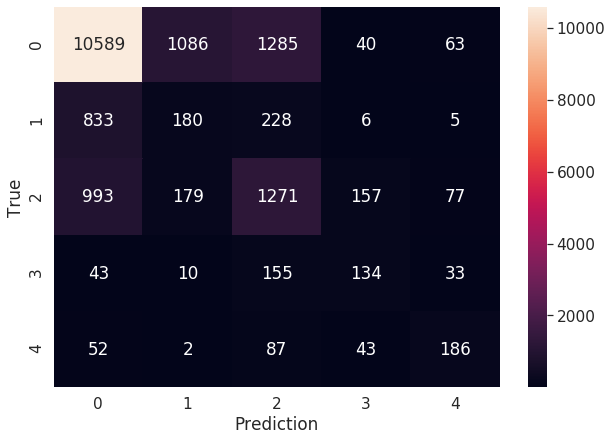

In [60]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [61]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [62]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [63]:
model_fp = 'tune/smote2_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [64]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
97/97 [==============================] - 1s 10ms/step - loss: 1.5524 - accuracy: 0.3263 - val_loss: 1.1511 - val_accuracy: 0.5152

Epoch 00001: val_accuracy improved from -inf to 0.51517, saving model to tune/smote2_moreDense_bias.h5
Epoch 2/200
97/97 [==============================] - 1s 6ms/step - loss: 1.1211 - accuracy: 0.4953 - val_loss: 1.0139 - val_accuracy: 0.6032

Epoch 00002: val_accuracy improved from 0.51517 to 0.60317, saving model to tune/smote2_moreDense_bias.h5
Epoch 3/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0566 - accuracy: 0.5282 - val_loss: 1.1492 - val_accuracy: 0.4225

Epoch 00003: val_accuracy did not improve from 0.60317
Epoch 4/200
97/97 [==============================] - 1s 6ms/step - loss: 1.0003 - accuracy: 0.5620 - val_loss: 1.0586 - val_accuracy: 0.5627

Epoch 00004: val_accuracy did not improve from 0.60317
Epoch 5/200
97/97 [==============================] - 1s 6ms/step - loss: 0.9856 - accuracy: 0.5661 - val_loss: 1

97/97 [==============================] - 1s 6ms/step - loss: 0.4290 - accuracy: 0.8283 - val_loss: 1.0988 - val_accuracy: 0.5495

Epoch 00041: val_accuracy did not improve from 0.69491
Epoch 42/200
97/97 [==============================] - 1s 6ms/step - loss: 0.4289 - accuracy: 0.8289 - val_loss: 1.0599 - val_accuracy: 0.5778

Epoch 00042: val_accuracy did not improve from 0.69491
Epoch 43/200
97/97 [==============================] - 1s 6ms/step - loss: 0.4177 - accuracy: 0.8349 - val_loss: 1.2481 - val_accuracy: 0.4812

Epoch 00043: val_accuracy did not improve from 0.69491
Epoch 44/200
97/97 [==============================] - 1s 6ms/step - loss: 0.4219 - accuracy: 0.8329 - val_loss: 1.0421 - val_accuracy: 0.5988

Epoch 00044: val_accuracy did not improve from 0.69491
Epoch 45/200
97/97 [==============================] - 1s 6ms/step - loss: 0.4130 - accuracy: 0.8376 - val_loss: 1.0895 - val_accuracy: 0.5640

Epoch 00045: val_accuracy did not improve from 0.69491
Epoch 46/200
97/97 [===

97/97 [==============================] - 1s 6ms/step - loss: 0.2402 - accuracy: 0.9114 - val_loss: 1.1711 - val_accuracy: 0.6426

Epoch 00082: val_accuracy did not improve from 0.71019
Epoch 83/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2397 - accuracy: 0.9128 - val_loss: 1.2652 - val_accuracy: 0.6002

Epoch 00083: val_accuracy did not improve from 0.71019
Epoch 84/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2420 - accuracy: 0.9086 - val_loss: 1.2650 - val_accuracy: 0.6036

Epoch 00084: val_accuracy did not improve from 0.71019
Epoch 85/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2231 - accuracy: 0.9192 - val_loss: 1.1178 - val_accuracy: 0.6942

Epoch 00085: val_accuracy did not improve from 0.71019
Epoch 86/200
97/97 [==============================] - 1s 6ms/step - loss: 0.2225 - accuracy: 0.9198 - val_loss: 1.2435 - val_accuracy: 0.6230

Epoch 00086: val_accuracy did not improve from 0.71019
Epoch 87/200
97/97 [===

In [65]:
model = load_model('tune/smote2_moreDense_bias.h5')

In [66]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7091390877826014
Classification Report
              precision    recall  f1-score   support

           0      0.853     0.825     0.839     13063
           1      0.130     0.143     0.136      1252
           2      0.434     0.493     0.462      2677
           3      0.390     0.336     0.361       375
           4      0.487     0.468     0.477       370

    accuracy                          0.709     17737
   macro avg      0.459     0.453     0.455     17737
weighted avg      0.721     0.709     0.715     17737



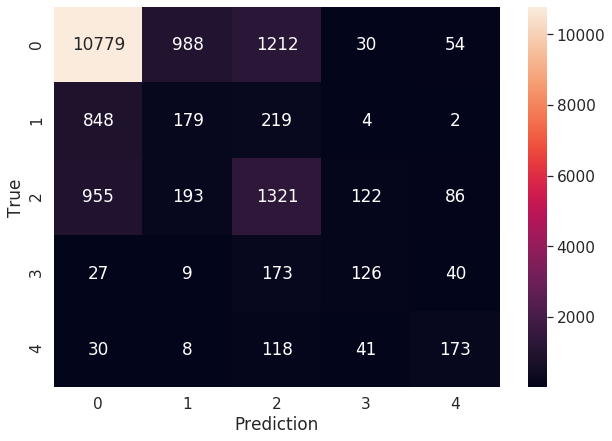

In [67]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

## SMOTE - undersample level 0 to 30k then balance all classes

Run smote if no prior re-sampling performed

In [68]:
train = [[vector, train_labels[img_fn]]
         for img_fn, vector in train_data.items()]
x_train_vec = np.array(list(map(lambda x: x[0], train)))
y_train_true = list(map(lambda x: x[1], train))
del train

Undersample level 0 to 20000

In [69]:
np.bincount(y_train_true)

array([39208,  3718,  7862,  1276,  1142])

In [70]:
n_samples = 30000
y_train_true = np.array(y_train_true)

# Get only class 0
x_train_0 = x_train_vec[y_train_true==0]
y_train_0 = y_train_true[y_train_true==0]

# Resample the class
x_train_0, y_train_0 = resample(x_train_0, y_train_0, replace=False,
                        n_samples=n_samples,
                        random_state=1)

# Remove all class 0 from source
x_train_vec = [x for x, y in zip(x_train_vec, y_train_true)
                        if y != 0]
y_train_true = list(filter(lambda y: y!=0, y_train_true))

# Append resample data of class 0
x_train_vec.extend(x_train_0)
y_train_true.extend(y_train_0)

del x_train_0, y_train_0
np.bincount(y_train_true)

array([30000,  3718,  7862,  1276,  1142])

In [71]:
sm = SMOTE(random_state=1)
x_train_sm, y_train_sm = sm.fit_sample(x_train_vec, y_train_true)

In [72]:
x_train_sm = np.array(x_train_sm)
y_train_true = y_train_sm
y_train_sm = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_train_sm)))

In [73]:
Counter(y_train_true)

Counter({2: 30000, 1: 30000, 4: 30000, 3: 30000, 0: 30000})

In [74]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   cooldown=3,
                                   verbose=0,
                                   min_lr=0.0001)
early = EarlyStopping(monitor="val_accuracy", 
                      verbose=0,
                      patience=30)

### Base

In [75]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [76]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [77]:
model_fp = 'tune/smote2_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [78]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
146/146 [==============================] - 1s 5ms/step - loss: 1.3846 - accuracy: 0.3771 - val_loss: 1.1743 - val_accuracy: 0.5274

Epoch 00001: val_accuracy improved from -inf to 0.52740, saving model to tune/smote2_base.h5
Epoch 2/200
146/146 [==============================] - 1s 4ms/step - loss: 1.1578 - accuracy: 0.4844 - val_loss: 1.3162 - val_accuracy: 0.3108

Epoch 00002: val_accuracy did not improve from 0.52740
Epoch 3/200
146/146 [==============================] - 1s 4ms/step - loss: 1.1111 - accuracy: 0.5105 - val_loss: 1.1766 - val_accuracy: 0.4139

Epoch 00003: val_accuracy did not improve from 0.52740
Epoch 4/200
146/146 [==============================] - 1s 4ms/step - loss: 1.0871 - accuracy: 0.5190 - val_loss: 1.1928 - val_accuracy: 0.4063

Epoch 00004: val_accuracy did not improve from 0.52740
Epoch 5/200
146/146 [==============================] - 1s 4ms/step - loss: 1.0763 - accuracy: 0.5234 - val_loss: 1.2177 - val_accuracy: 0.3027

Epoch 00005: val_accur

In [79]:
model = load_model('tune/smote2_base.h5')

In [80]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.5270338839713593
Classification Report
              precision    recall  f1-score   support

           0      0.838     0.611     0.707     13063
           1      0.109     0.286     0.158      1252
           2      0.257     0.219     0.236      2677
           3      0.132     0.443     0.203       375
           4      0.185     0.695     0.293       370

    accuracy                          0.527     17737
   macro avg      0.304     0.451     0.319     17737
weighted avg      0.670     0.527     0.578     17737



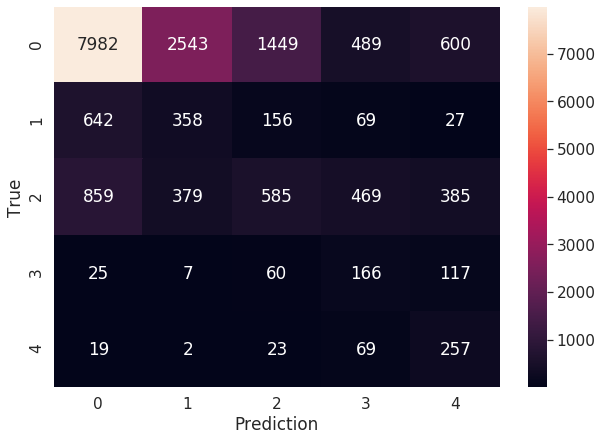

In [81]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [82]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [83]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [84]:
model_fp = 'tune/smote2_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [85]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
146/146 [==============================] - 1s 7ms/step - loss: 1.2801 - accuracy: 0.4248 - val_loss: 1.2207 - val_accuracy: 0.4416

Epoch 00001: val_accuracy improved from -inf to 0.44164, saving model to tune/smote2_dropToDense.h5
Epoch 2/200
146/146 [==============================] - 1s 6ms/step - loss: 1.0252 - accuracy: 0.5460 - val_loss: 1.1779 - val_accuracy: 0.3640

Epoch 00002: val_accuracy did not improve from 0.44164
Epoch 3/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9581 - accuracy: 0.5797 - val_loss: 1.0249 - val_accuracy: 0.5350

Epoch 00003: val_accuracy improved from 0.44164 to 0.53504, saving model to tune/smote2_dropToDense.h5
Epoch 4/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9201 - accuracy: 0.5961 - val_loss: 0.9445 - val_accuracy: 0.5828

Epoch 00004: val_accuracy improved from 0.53504 to 0.58284, saving model to tune/smote2_dropToDense.h5
Epoch 5/200
146/146 [==============================] - 1s 6ms/s

146/146 [==============================] - 1s 6ms/step - loss: 0.1503 - accuracy: 0.9474 - val_loss: 1.2395 - val_accuracy: 0.6672

Epoch 00040: val_accuracy did not improve from 0.69566
Epoch 41/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1424 - accuracy: 0.9508 - val_loss: 1.2481 - val_accuracy: 0.6791

Epoch 00041: val_accuracy did not improve from 0.69566
Epoch 42/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1426 - accuracy: 0.9505 - val_loss: 1.3125 - val_accuracy: 0.6422

Epoch 00042: val_accuracy did not improve from 0.69566
Epoch 43/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1345 - accuracy: 0.9538 - val_loss: 1.2931 - val_accuracy: 0.6558

Epoch 00043: val_accuracy did not improve from 0.69566
Epoch 44/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1263 - accuracy: 0.9579 - val_loss: 1.2928 - val_accuracy: 0.6661

Epoch 00044: val_accuracy did not improve from 0.69566
Epoch 45/200



Epoch 00080: val_accuracy improved from 0.70755 to 0.70784, saving model to tune/smote2_dropToDense.h5
Epoch 81/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0527 - accuracy: 0.9854 - val_loss: 1.6507 - val_accuracy: 0.7231

Epoch 00081: val_accuracy improved from 0.70784 to 0.72312, saving model to tune/smote2_dropToDense.h5
Epoch 82/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0533 - accuracy: 0.9846 - val_loss: 1.6824 - val_accuracy: 0.7054

Epoch 00082: val_accuracy did not improve from 0.72312
Epoch 83/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9857 - val_loss: 1.7002 - val_accuracy: 0.6967

Epoch 00083: val_accuracy did not improve from 0.72312
Epoch 84/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9869 - val_loss: 1.7268 - val_accuracy: 0.6881

Epoch 00084: val_accuracy did not improve from 0.72312
Epoch 85/200
146/146 [==========================

In [86]:
model = load_model('tune/smote2_dropToDense.h5')

In [87]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7227265039183628
Classification Report
              precision    recall  f1-score   support

           0      0.834     0.857     0.846     13063
           1      0.135     0.141     0.138      1252
           2      0.472     0.427     0.448      2677
           3      0.465     0.315     0.375       375
           4      0.553     0.495     0.522       370

    accuracy                          0.723     17737
   macro avg      0.492     0.447     0.466     17737
weighted avg      0.717     0.723     0.719     17737



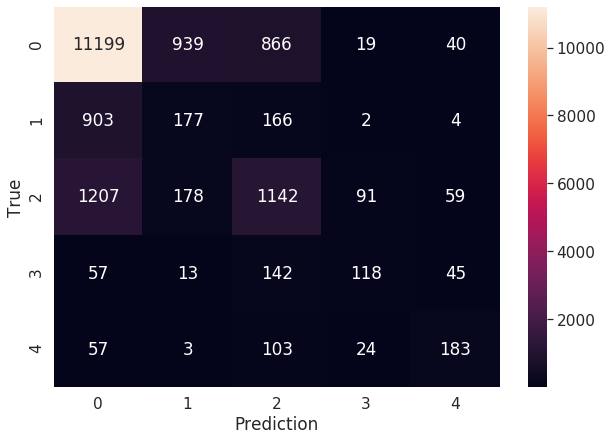

In [88]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [89]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [90]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [91]:
model_fp = 'tune/smote2_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [92]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
146/146 [==============================] - 1s 7ms/step - loss: 1.3033 - accuracy: 0.4077 - val_loss: 1.1486 - val_accuracy: 0.4659

Epoch 00001: val_accuracy improved from -inf to 0.46588, saving model to tune/smote2_dropToDense_weighted.h5
Epoch 2/200
146/146 [==============================] - 1s 6ms/step - loss: 1.0255 - accuracy: 0.5448 - val_loss: 1.1709 - val_accuracy: 0.4038

Epoch 00002: val_accuracy did not improve from 0.46588
Epoch 3/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9523 - accuracy: 0.5833 - val_loss: 1.0171 - val_accuracy: 0.5287

Epoch 00003: val_accuracy improved from 0.46588 to 0.52872, saving model to tune/smote2_dropToDense_weighted.h5
Epoch 4/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9095 - accuracy: 0.6030 - val_loss: 1.0345 - val_accuracy: 0.5210

Epoch 00004: val_accuracy did not improve from 0.52872
Epoch 5/200
146/146 [==============================] - 1s 6ms/step - loss: 0.8806 - accuracy:

146/146 [==============================] - 1s 6ms/step - loss: 0.1961 - accuracy: 0.9305 - val_loss: 1.1279 - val_accuracy: 0.6752

Epoch 00039: val_accuracy did not improve from 0.72622
Epoch 40/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1925 - accuracy: 0.9315 - val_loss: 1.1164 - val_accuracy: 0.6845

Epoch 00040: val_accuracy did not improve from 0.72622
Epoch 41/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1883 - accuracy: 0.9327 - val_loss: 1.1569 - val_accuracy: 0.6658

Epoch 00041: val_accuracy did not improve from 0.72622
Epoch 42/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1819 - accuracy: 0.9361 - val_loss: 1.1683 - val_accuracy: 0.6655

Epoch 00042: val_accuracy did not improve from 0.72622
Epoch 43/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1808 - accuracy: 0.9359 - val_loss: 1.1868 - val_accuracy: 0.6623

Epoch 00043: val_accuracy did not improve from 0.72622
Epoch 44/200


In [93]:
model = load_model('tune/smote2_dropToDense_weighted.h5')

In [94]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7257709872018944
Classification Report
              precision    recall  f1-score   support

           0      0.840     0.858     0.849     13063
           1      0.138     0.149     0.144      1252
           2      0.488     0.434     0.459      2677
           3      0.394     0.379     0.386       375
           4      0.580     0.462     0.514       370

    accuracy                          0.726     17737
   macro avg      0.488     0.456     0.470     17737
weighted avg      0.722     0.726     0.724     17737



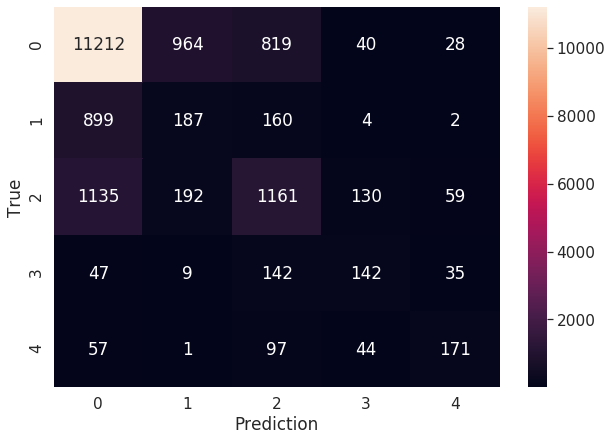

In [95]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [96]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [97]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [98]:
model_fp = 'tune/smote2_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [99]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
146/146 [==============================] - 1s 8ms/step - loss: 1.3122 - accuracy: 0.4047 - val_loss: 1.2832 - val_accuracy: 0.3170

Epoch 00001: val_accuracy improved from -inf to 0.31704, saving model to tune/smote2_moreDense.h5
Epoch 2/200
146/146 [==============================] - 1s 6ms/step - loss: 1.0373 - accuracy: 0.5383 - val_loss: 1.0026 - val_accuracy: 0.5644

Epoch 00002: val_accuracy improved from 0.31704 to 0.56440, saving model to tune/smote2_moreDense.h5
Epoch 3/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9594 - accuracy: 0.5795 - val_loss: 1.0341 - val_accuracy: 0.5256

Epoch 00003: val_accuracy did not improve from 0.56440
Epoch 4/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9221 - accuracy: 0.5968 - val_loss: 0.9115 - val_accuracy: 0.6318

Epoch 00004: val_accuracy improved from 0.56440 to 0.63178, saving model to tune/smote2_moreDense.h5
Epoch 5/200
146/146 [==============================] - 1s 6ms/step - 

146/146 [==============================] - 1s 6ms/step - loss: 0.1200 - accuracy: 0.9573 - val_loss: 1.4526 - val_accuracy: 0.6793

Epoch 00040: val_accuracy did not improve from 0.70278
Epoch 41/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1065 - accuracy: 0.9635 - val_loss: 1.4531 - val_accuracy: 0.6896

Epoch 00041: val_accuracy did not improve from 0.70278
Epoch 42/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1041 - accuracy: 0.9650 - val_loss: 1.5278 - val_accuracy: 0.6788

Epoch 00042: val_accuracy did not improve from 0.70278
Epoch 43/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1021 - accuracy: 0.9643 - val_loss: 1.5280 - val_accuracy: 0.6782

Epoch 00043: val_accuracy did not improve from 0.70278
Epoch 44/200
146/146 [==============================] - 1s 6ms/step - loss: 0.1003 - accuracy: 0.9656 - val_loss: 1.5555 - val_accuracy: 0.6710

Epoch 00044: val_accuracy did not improve from 0.70278
Epoch 45/200


In [100]:
model = load_model('tune/smote2_moreDense.h5')

In [101]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7025427073349495
Classification Report
              precision    recall  f1-score   support

           0      0.843     0.820     0.831     13063
           1      0.126     0.151     0.138      1252
           2      0.436     0.472     0.454      2677
           3      0.401     0.333     0.364       375
           4      0.540     0.478     0.507       370

    accuracy                          0.703     17737
   macro avg      0.469     0.451     0.459     17737
weighted avg      0.715     0.703     0.708     17737



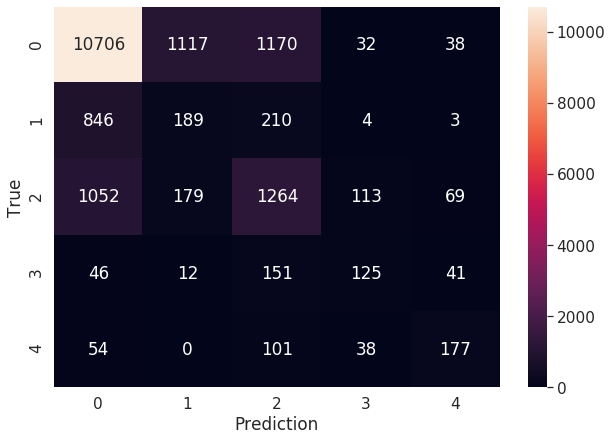

In [102]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [103]:
def create_toplayers():
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [104]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [105]:
model_fp = 'tune/smote2_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [106]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
146/146 [==============================] - 1s 8ms/step - loss: 1.6125 - accuracy: 0.3184 - val_loss: 1.3889 - val_accuracy: 0.2015

Epoch 00001: val_accuracy improved from -inf to 0.20152, saving model to tune/smote2_moreDense_bias.h5
Epoch 2/200
146/146 [==============================] - 1s 6ms/step - loss: 1.1017 - accuracy: 0.5041 - val_loss: 1.3840 - val_accuracy: 0.2949

Epoch 00002: val_accuracy improved from 0.20152 to 0.29486, saving model to tune/smote2_moreDense_bias.h5
Epoch 3/200
146/146 [==============================] - 1s 6ms/step - loss: 1.0304 - accuracy: 0.5425 - val_loss: 1.0087 - val_accuracy: 0.5609

Epoch 00003: val_accuracy improved from 0.29486 to 0.56095, saving model to tune/smote2_moreDense_bias.h5
Epoch 4/200
146/146 [==============================] - 1s 6ms/step - loss: 0.9785 - accuracy: 0.5708 - val_loss: 0.9426 - val_accuracy: 0.6262

Epoch 00004: val_accuracy improved from 0.56095 to 0.62621, saving model to tune/smote2_moreDense_bias.h5
Epo

146/146 [==============================] - 1s 6ms/step - loss: 0.2386 - accuracy: 0.9107 - val_loss: 1.2522 - val_accuracy: 0.6051

Epoch 00040: val_accuracy did not improve from 0.67733
Epoch 41/200
146/146 [==============================] - 1s 6ms/step - loss: 0.2313 - accuracy: 0.9141 - val_loss: 1.1149 - val_accuracy: 0.6938

Epoch 00041: val_accuracy improved from 0.67733 to 0.69376, saving model to tune/smote2_moreDense_bias.h5
Epoch 42/200
146/146 [==============================] - 1s 6ms/step - loss: 0.2278 - accuracy: 0.9149 - val_loss: 1.1676 - val_accuracy: 0.6747

Epoch 00042: val_accuracy did not improve from 0.69376
Epoch 43/200
146/146 [==============================] - 1s 6ms/step - loss: 0.2220 - accuracy: 0.9188 - val_loss: 1.1997 - val_accuracy: 0.6547

Epoch 00043: val_accuracy did not improve from 0.69376
Epoch 44/200
146/146 [==============================] - 1s 6ms/step - loss: 0.2236 - accuracy: 0.9159 - val_loss: 1.2162 - val_accuracy: 0.6504

Epoch 00044: val_

146/146 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9723 - val_loss: 1.6963 - val_accuracy: 0.7157

Epoch 00080: val_accuracy did not improve from 0.71950
Epoch 81/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0914 - accuracy: 0.9683 - val_loss: 1.7183 - val_accuracy: 0.6843

Epoch 00081: val_accuracy did not improve from 0.71950
Epoch 82/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0739 - accuracy: 0.9762 - val_loss: 1.7777 - val_accuracy: 0.7025

Epoch 00082: val_accuracy did not improve from 0.71950
Epoch 83/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0742 - accuracy: 0.9758 - val_loss: 1.7866 - val_accuracy: 0.6739

Epoch 00083: val_accuracy did not improve from 0.71950
Epoch 84/200
146/146 [==============================] - 1s 6ms/step - loss: 0.0741 - accuracy: 0.9753 - val_loss: 1.7479 - val_accuracy: 0.7172

Epoch 00084: val_accuracy did not improve from 0.71950
Epoch 85/200


In [107]:
model = load_model('tune/smote2_moreDense_bias.h5')

In [108]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7191182274341772
Classification Report
              precision    recall  f1-score   support

           0      0.844     0.847     0.846     13063
           1      0.136     0.074     0.096      1252
           2      0.403     0.474     0.436      2677
           3      0.341     0.421     0.377       375
           4      0.519     0.454     0.484       370

    accuracy                          0.719     17737
   macro avg      0.448     0.454     0.448     17737
weighted avg      0.710     0.719     0.713     17737



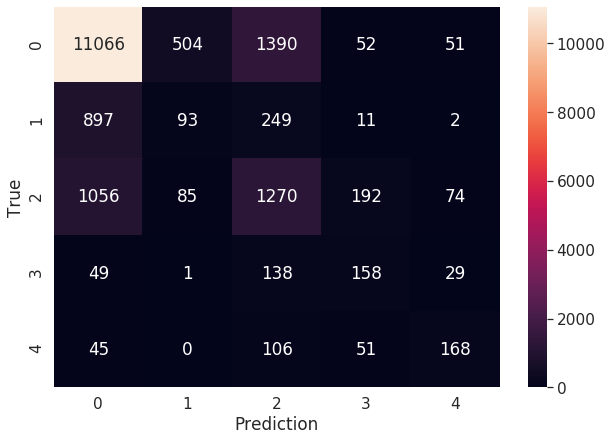

In [109]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")